In [84]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
dataset = [[2.7810836,2.550537003],
	[1.465489372,2.362125076],
	[3.396561688,4.400293529],
	[1.38807019,1.850220317],
	[3.06407232,3.005305973],
	[7.627531214,2.759262235],
	[5.332441248,2.088626775],
	[6.922596716,1.77106367],
	[8.675418651,-0.242068655],
	[7.673756466,3.508563011]]
x_vals=np.array([x[0] for x in dataset])
y_vals=np.array([y[1] for y in dataset])
print(x_vals)
print(y_vals)

[ 2.7810836   1.46548937  3.39656169  1.38807019  3.06407232  7.62753121
  5.33244125  6.92259672  8.67541865  7.67375647]
[ 2.550537    2.36212508  4.40029353  1.85022032  3.00530597  2.75926224
  2.08862677  1.77106367 -0.24206865  3.50856301]


In [85]:
regression_type = 'LASSO'

In [86]:
# clear out old graph
ops.reset_default_graph()

# Create graph
sess = tf.Session()

In [87]:
# Declare batch size
batch_size = 50

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# make results reproducible
seed = 13
np.random.seed(seed)
tf.set_random_seed(seed)

# Create variables for linear regression
A = tf.Variable(tf.random_normal(shape=[1,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Declare model operations
model_output = tf.add(tf.matmul(x_data, A), b)

In [88]:
#Select appropriate loss function based on regression type

if regression_type == 'LASSO':
    # Declare Lasso loss function
    # Lasso Loss = L2_Loss + heavyside_step,
    # Where heavyside_step ~ 0 if A < constant, otherwise ~ 99
    lasso_param = tf.constant(0.9)
    heavyside_step = tf.truediv(1., tf.add(1., tf.exp(tf.multiply(-50., tf.subtract(A, lasso_param)))))
    regularization_param = tf.multiply(heavyside_step, 99.)
    loss = tf.add(tf.reduce_mean(tf.square(y_target - model_output)), regularization_param)

elif regression_type == 'Ridge':
    # Declare the Ridge loss function
    # Ridge loss = L2_loss + L2 norm of slope
    ridge_param = tf.constant(1.)
    ridge_loss = tf.reduce_mean(tf.square(A))
    loss = tf.expand_dims(tf.add(tf.reduce_mean(tf.square(y_target - model_output)), tf.multiply(ridge_param, ridge_loss)), 0)
    
else:
    print('Invalid regression_type parameter value',file=sys.stderr)

In [89]:
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

In [90]:
# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Training loop
loss_vec = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = np.transpose([x_vals[rand_index]])
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss[0])
    if (i+1)%300==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)) + ' b = ' + str(sess.run(b)))
        print('Loss = ' + str(temp_loss))
        print('\n')

Step #300 A = [[ 0.38805175]] b = [[-0.2273259]]
Loss = [[ 5.13598156]]


Step #600 A = [[ 0.32053968]] b = [[ 0.18024607]]
Loss = [[ 3.97330618]]


Step #900 A = [[ 0.26309466]] b = [[ 0.54356939]]
Loss = [[ 3.7472055]]


Step #1200 A = [[ 0.23406911]] b = [[ 0.86393005]]
Loss = [[ 3.23370123]]


Step #1500 A = [[ 0.17263851]] b = [[ 1.13357687]]
Loss = [[ 1.10757542]]




In [91]:
# Get the optimal coefficients
[slope] = sess.run(A)
[y_intercept] = sess.run(b)

# Get best fit line
best_fit = []
for i in x_vals:
  best_fit.append(slope*i+y_intercept)


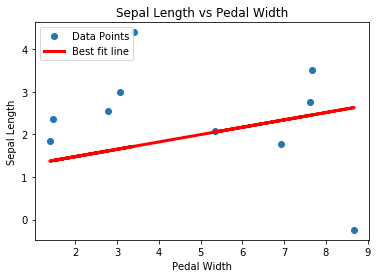

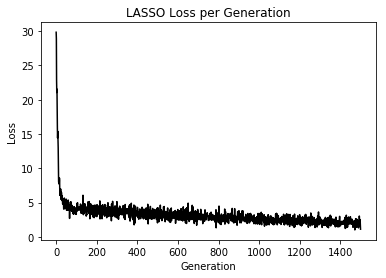

In [92]:
%matplotlib inline
# Plot the result
plt.plot(x_vals, y_vals, 'o', label='Data Points')
plt.plot(x_vals, best_fit, 'r-', label='Best fit line', linewidth=3)
plt.legend(loc='upper left')
plt.title('Sepal Length vs Pedal Width')
plt.xlabel('Pedal Width')
plt.ylabel('Sepal Length')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title(regression_type + ' Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()